# Xenium EAE 5K Processing Walkthrough

This notebook is organized as a step-by-step pipeline from raw Xenium outputs to clustered and spatially visualized cells. Each code cell now has a short markdown guide explaining its purpose, key operations, and expected output so the workflow is easier to review and maintain.


## Step 01: Set Up The Analysis Environment

Import all required libraries and suppress noisy warnings so downstream output is easier to read.

**What this cell does**
- Loads Scanpy, pandas, NumPy, plotting tools, and clustering utilities.
- Keeps notebook output focused on actionable messages during processing.


In [44]:
import warnings
warnings.filterwarnings('ignore')
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

## Step 02: Load Xenium Runs And Attach Metadata

Find each run folder, read expression matrices plus per-cell metadata, and store them as a list of AnnData objects.

**What this cell does**
- Scans `base_dir` for folders that start with `output-`.
- Reads `cell_feature_matrix.h5` and `cells.csv.gz` for each valid run.
- Adds a `run` label so we can trace every cell back to its origin.


In [45]:
base_dir = '/Users/chrislangseth/Downloads/fetal_lung'

runs = [d for d in os.listdir(base_dir) if d.startswith("output-") and os.path.isdir(os.path.join(base_dir, d))]

ad_list = []

for run in runs:
    run_path = os.path.join(base_dir, run)

    # Define file paths directly in each run folder
    h5_path = os.path.join(run_path, 'cell_feature_matrix.h5')
    cell_info_path = os.path.join(run_path, 'cells.csv.gz')

    if not (os.path.exists(h5_path) and os.path.exists(cell_info_path)):
        print(f"Skipping {run_path} (missing required files)")
        continue

    print(f"Loading: {run}")
    ad_int = sc.read_10x_h5(h5_path)
    cell_info = pd.read_csv(cell_info_path, index_col=0)

    ad_int.obs = cell_info
    ad_int.obs['run'] = run

    ad_list.append(ad_int)

Loading: output-XETG00077__0040306__11155-TF-1_ROI_C__20240621__173354
Loading: output-XETG00077__0040306__11155-TF-1_ROI_A2__20240621__173354
Loading: output-XETG00077__0040306__11155-TF-1_ROI_B2__20240621__173354
Loading: output-XETG00077__0040306__11155-TF-1_ROI_B1__20240621__173354
Loading: output-XETG00077__0040306__11155-TF-1_ROI_A1__20240621__173354


## Step 03: Concatenate Runs Into One AnnData Object

Merge all loaded run-level objects into a single dataset for unified analysis.

**What this cell does**
- Creates one combined `ad` object from `ad_list`.
- Enables end-to-end QC, clustering, and visualization across runs.


In [46]:
ad = sc.concat(ad_list)

## Step 04: Inspect Cell Metadata

Quickly inspect `ad.obs` to confirm metadata columns are present and correctly populated.

**What this cell does**
- Verifies that per-cell annotations loaded correctly.
- Helps catch missing fields before preprocessing.


In [47]:
ad.obs

x_centroid   y_centroid  transcript_counts  control_probe_counts  \
cell_id                                                                         
aaaaaolf-1   630.566406  1751.735352                  0                     0   
aaaafncc-1   988.091309  1773.142822                  0                     0   
aaaainbl-1   717.520874  1794.558350                  2                     0   
aaaajhne-1   646.734924  1746.072266                  0                     0   
aaaamlpp-1  1104.949341  2115.699951                 64                     0   
...                 ...          ...                ...                   ...   
oikldpcp-1  3711.708252  4047.866943                  2                     0   
oikmcmfe-1  3726.701904  4048.486084                  3                     0   
oikmfoph-1  3714.452393  4042.036865                 39                     0   
oiknbikk-1  3573.137695  3033.785156                 75                     0   
oiknfkcp-1  3532.488037  2999.935303                 24                     0   

            control_codeword_counts  unassigned_codeword_counts  \
cell_id                                                           
aaaaaolf-1                        0                           0   
aaaafncc-1                        0                           0   
aaaainbl-1                        0                           0   
aaaajhne-1                        0                           0   
aaaamlpp-1                        0                           0   
...                             ...                         ...   
oikldpcp-1                        0                           0   
oikmcmfe-1                        0                           0   
oikmfoph-1                        0                           0   
oiknbikk-1                        0                           0   
oiknfkcp-1                        0                           0   

            deprecated_codeword_counts  total_counts   cell_area  \
cell_id                                                            
aaaaaolf-1                           0             0  309.997668   
aaaafncc-1                           0             0   64.167034   
aaaainbl-1                           0             2   41.408283   
aaaajhne-1                           0             0   57.574221   
aaaamlpp-1                           0            64   38.563439   
...                                ...           ...         ...   
oikldpcp-1                           0             2   16.752969   
oikmcmfe-1                           0             3   32.783439   
oikmfoph-1                           0            39  133.120630   
oiknbikk-1                           0            75   36.576564   
oiknfkcp-1                           0            24   25.468126   

            nucleus_area                                                run  
cell_id                                                                      
aaaaaolf-1           NaN  output-XETG00077__0040306__11155-TF-1_ROI_C__2...  
aaaafncc-1           NaN  output-XETG00077__0040306__11155-TF-1_ROI_C__2...  
aaaainbl-1           NaN  output-XETG00077__0040306__11155-TF-1_ROI_C__2...  
aaaajhne-1           NaN  output-XETG00077__0040306__11155-TF-1_ROI_C__2...  
aaaamlpp-1     22.307188  output-XETG00077__0040306__11155-TF-1_ROI_C__2...  
...                  ...                                                ...  
oikldpcp-1     16.752969  output-XETG00077__0040306__11155-TF-1_ROI_A1__...  
oikmcmfe-1     32.783439  output-XETG00077__0040306__11155-TF-1_ROI_A1__...  
oikmfoph-1     28.267814  output-XETG00077__0040306__11155-TF-1_ROI_A1__...  
oiknbikk-1     32.512501  output-XETG00077__0040306__11155-TF-1_ROI_A1__...  
oiknfkcp-1     25.468126  output-XETG00077__0040306__11155-TF-1_ROI_A1__...  

[820655 rows x 11 columns]

## Step 05: Preserve Raw Counts

Store a copy of the original count matrix before normalization and filtering.

**What this cell does**
- Saves raw expression values to `ad.layers["counts"]`.
- Protects an untouched baseline for later comparisons.


In [48]:
ad.layers['counts'] = ad.X.copy()

## Step 06: Write A Raw Data Checkpoint

Save the unprocessed object so this stage can be reused without reloading raw files.

**What this cell does**
- Writes checkpoint file `data/260210_raw.h5ad`.
- Makes the workflow restartable from a known state.


In [49]:
#RENAME 
ad.write('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_raw.h5ad')

## Step 07: Compute QC Metrics

Calculate quality-control summaries for each cell and gene.

**What this cell does**
- Adds fields such as total counts and detected genes to metadata.
- Provides metrics used in filtering and dashboard plots.


In [50]:
#Information om celler, counts, unika gener etc. 

sc.pp.calculate_qc_metrics(ad, percent_top=None, log1p=False, inplace=True)


## Step 08: Normalize Index Handling In Metadata

Reset the observation index so identifier columns are explicit and easy to group on.

**What this cell does**
- Moves index values into a regular column.
- Simplifies groupby operations used in QC summaries.


In [51]:
#Flyttar ut kolumn
ad.obs = ad.obs.reset_index()

## Step 09: Derive Sample IDs

Create a cleaner sample identifier by parsing the `run` string.

**What this cell does**
- Splits run names on `__` and extracts the sample component.
- Creates `ad.obs["sample_id"]` for plotting and comparisons.


In [52]:
# Skapar sample_id kolumn utifrån run kolumn
ad.obs['sample_id'] = ad.obs.run.str.split('__', expand = True)[2]

In [53]:
ad.obs['sample_id']

0          11155-TF-1_ROI_C
1          11155-TF-1_ROI_C
2          11155-TF-1_ROI_C
3          11155-TF-1_ROI_C
4          11155-TF-1_ROI_C
                ...        
820650    11155-TF-1_ROI_A1
820651    11155-TF-1_ROI_A1
820652    11155-TF-1_ROI_A1
820653    11155-TF-1_ROI_A1
820654    11155-TF-1_ROI_A1
Name: sample_id, Length: 820655, dtype: object

## Step 10: Verify Updated Metadata Table

Display `ad.obs` again to confirm the new metadata structure and sample IDs.

**What this cell does**
- Checks that `sample_id` exists and looks correct.
- Confirms data shape before visualization steps.


In [54]:
ad.obs

cell_id   x_centroid   y_centroid  transcript_counts  \
0       aaaaaolf-1   630.566406  1751.735352                  0   
1       aaaafncc-1   988.091309  1773.142822                  0   
2       aaaainbl-1   717.520874  1794.558350                  2   
3       aaaajhne-1   646.734924  1746.072266                  0   
4       aaaamlpp-1  1104.949341  2115.699951                 64   
...            ...          ...          ...                ...   
820650  oikldpcp-1  3711.708252  4047.866943                  2   
820651  oikmcmfe-1  3726.701904  4048.486084                  3   
820652  oikmfoph-1  3714.452393  4042.036865                 39   
820653  oiknbikk-1  3573.137695  3033.785156                 75   
820654  oiknfkcp-1  3532.488037  2999.935303                 24   

        control_probe_counts  control_codeword_counts  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   
...                      ...                      ...   
820650                     0                        0   
820651                     0                        0   
820652                     0                        0   
820653                     0                        0   
820654                     0                        0   

        unassigned_codeword_counts  deprecated_codeword_counts  total_counts  \
0                                0                           0           0.0   
1                                0                           0           0.0   
2                                0                           0           2.0   
3                                0                           0           0.0   
4                                0                           0          64.0   
...                            ...                         ...           ...   
820650                           0                           0           2.0   
820651                           0                           0           3.0   
820652                           0                           0          39.0   
820653                           0                           0          75.0   
820654                           0                           0          24.0   

         cell_area  nucleus_area  \
0       309.997668           NaN   
1        64.167034           NaN   
2        41.408283           NaN   
3        57.574221           NaN   
4        38.563439     22.307188   
...            ...           ...   
820650   16.752969     16.752969   
820651   32.783439     32.783439   
820652  133.120630     28.267814   
820653   36.576564     32.512501   
820654   25.468126     25.468126   

                                                      run  n_genes_by_counts  \
0       output-XETG00077__0040306__11155-TF-1_ROI_C__2...                  0   
1       output-XETG00077__0040306__11155-TF-1_ROI_C__2...                  0   
2       output-XETG00077__0040306__11155-TF-1_ROI_C__2...                  2   
3       output-XETG00077__0040306__11155-TF-1_ROI_C__2...                  0   
4       output-XETG00077__0040306__11155-TF-1_ROI_C__2...                 36   
...                                                   ...                ...   
820650  output-XETG00077__0040306__11155-TF-1_ROI_A1__...                  2   
820651  output-XETG00077__0040306__11155-TF-1_ROI_A1__...                  3   
820652  output-XETG00077__0040306__11155-TF-1_ROI_A1__...                 31   
820653  output-XETG00077__0040306__11155-TF-1_ROI_A1__...                 39   
820654  output-XETG00077__0040306__11155-TF-1_ROI_A1__...                 22   

                sample_id  
0        11155-TF-1_ROI_C  
1        11155-TF-1_ROI_C  
2        11155-TF-1_ROI_C  
3        11155-TF-1_ROI_C  
4        11155-TF-1_ROI_C 

## Step 11: Build A Per-Sample QC Summary Table

Aggregate key metrics per sample to get a compact overview of dataset quality and scale.

**What this cell does**
- Computes number of cells, mean counts, and mean genes per sample.
- Sorts samples by cell count to highlight dominant runs.


In [55]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load your Xenium dataset ---
# --- Example: basic summary table ---
summary = (
    ad.obs.groupby("sample_id")
    .agg(
        n_cells=("cell_id", "count"),
        mean_counts=("total_counts", "mean"),
        mean_genes=("n_genes_by_counts", "mean"),
    )
    .sort_values("n_cells", ascending=False)
)

## Step 12: Style The QC Summary For Readability

Apply color gradients and number formatting to make summary values easier to scan.

**What this cell does**
- Uses pandas Styler to highlight relative magnitudes.
- Formats table values for clear reporting in the notebook.


In [56]:
# Pretty print with formatting
styled = (
    summary.style
    .background_gradient(subset=["n_cells"], cmap="Purples")
    .background_gradient(subset=["mean_counts"], cmap="Blues")
    .background_gradient(subset=["mean_genes"], cmap="Greens")
    .format({
        "n_cells": "{:,.0f}",
        "counts_mean": "{:.1f}",
        "counts_median": "{:.0f}",
        "counts_p10": "{:.0f}",
        "counts_p90": "{:.0f}",
        "genes_mean": "{:.1f}",
        "genes_median": "{:.0f}",
        "genes_p10": "{:.0f}",
        "genes_p90": "{:.0f}",
    })
    .set_caption("📊 Xenium QC Summary per Sample")
)
styled

## Step 13: Run A Full QC Dashboard And Export Figures

Generate a reusable QC report: summary CSV, per-run plots, composition charts, and gene detection coverage.

**What this cell does**
- Creates outputs under `xenium_qc/` (tables and PNG figures).
- Includes cell count, counts/genes distributions, composition, and detection-rate diagnostics.
- Handles optional columns gracefully so the cell can run on similar datasets.


## Step 15: Filter Low-Quality Cells

Remove cells with very low transcript counts or too few detected genes.

**What this cell does**
- Applies minimum thresholds for `min_counts` and `min_genes`.
- Reduces noise and stabilizes downstream embeddings and clustering.


In [57]:
sc.pp.filter_cells(ad,min_counts=15)
sc.pp.filter_cells(ad,min_genes=5)

## Step 16: Normalize And Log-Transform Expression

Scale counts per cell to a shared depth, then apply log transformation.

**What this cell does**
- Runs total-count normalization with a target sum of 100.
- Applies `log1p` so expression distributions are more comparable.


In [58]:
sc.pp.normalize_total(ad, inplace=True,target_sum=100)
sc.pp.log1p(ad)
#sc.pp.scale(ad, )#max_value=10)

## Step 17: Compute PCA And Neighbor Graph

Reduce dimensionality and build the neighbor graph that drives manifold learning and clustering.

**What this cell does**
- Calculates PCA and visualizes explained variance.
- Builds KNN graph using selected PCs and neighbor count.


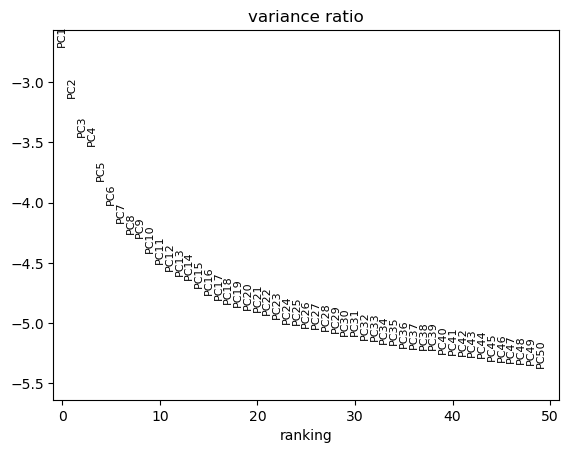

In [59]:
sc.tl.pca(ad)
sc.pl.pca_variance_ratio(ad, n_pcs=50, log=True)
sc.pp.neighbors(ad, n_neighbors=15, n_pcs=30)

## Step 18: Generate UMAP Embedding

Project cells into a 2D manifold for visual exploration of structure and clusters.

**What this cell does**
- Computes UMAP coordinates from the neighbor graph.
- Uses `min_dist=0.1` to control cluster compactness.


In [60]:
sc.tl.umap(ad, min_dist=0.1)

## Step 19: Plot UMAP By Sample

Color the UMAP by sample identity to inspect batch effects and sample mixing.

**What this cell does**
- Draws cells with small point size for dense visualization.
- Helps assess whether runs overlap in expression space.


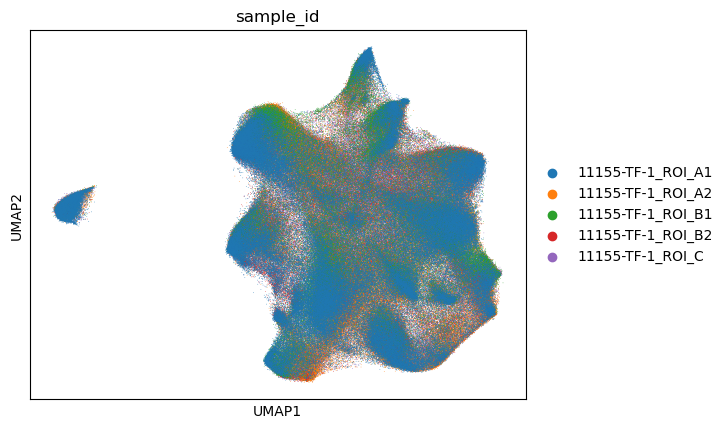

In [61]:
sc.pl.umap(ad, color=['sample_id'], s=1)

## Step 20: Run Multi-Resolution Leiden Clustering

Cluster the same embedding at several resolutions to compare coarse vs fine partitions.

**What this cell does**
- Creates labels like `leiden_0.1`, `leiden_0.5`, ..., `leiden_2`.
- Skips recomputation if a label already exists.
- Plots each clustering result on UMAP.


Clustering at resolution 0.1...
Done.


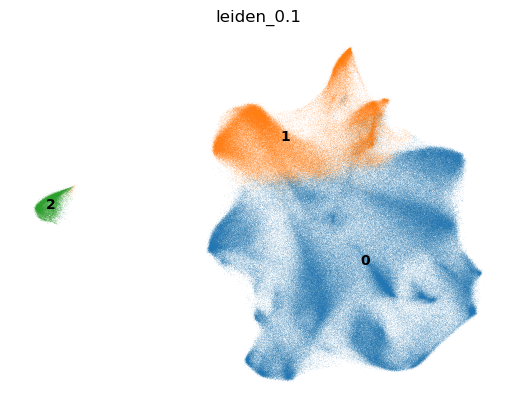

Clustering at resolution 0.5...
Done.


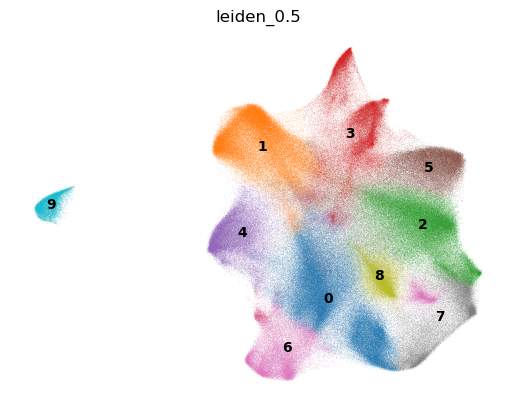

Clustering at resolution 1...


In [ ]:
resolutions = [0.1,0.5, 1,1.5, 2]

for resolution in resolutions:
    key = f'leiden_{resolution}'

    if key in ad.obs.columns:
        print(f"Skipping {resolution}: {key} already exists.")
    else:
        print(f"Clustering at resolution {resolution}...")
        sc.tl.leiden(ad, resolution=resolution, key_added=key)
        print("Done.")

    # plot UMAP
    sc.pl.umap(ad, color=key, legend_loc='on data', frameon=False)

## Step 21: Save Clustered Checkpoint

Persist the post-clustering AnnData object for later spatial and marker analysis.

**What this cell does**
- Writes `data/260210_clustered.h5ad`.
- Creates a stable checkpoint after expensive preprocessing.


In [ ]:
#RENAME (checkpoint)
ad.write('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_clustered.h5ad')

## Step 22: Reload Clustered Dataset

Load the saved checkpoint to continue work from a clean, reproducible state.

**What this cell does**
- Reads `data/260210_clustered.h5ad` into `ad`.
- Useful when resuming the notebook in a new session.


In [ ]:
#RENAME
ad = sc.read('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_clustered.h5ad')

## Step 23: Attach Spatial Coordinates

Build the standard `obsm["spatial"]` matrix from centroid columns.

**What this cell does**
- Uses `x_centroid` and `y_centroid` from metadata.
- Prepares data for custom spatial plotting functions.


In [ ]:
spatial = np.array(ad.obs[['x_centroid','y_centroid']])
ad.obsm['spatial'] = spatial

## Step 24: Confirm Spatial Embedding Is Present

Display the AnnData object to verify that spatial coordinates are registered.

**What this cell does**
- Quick sanity check before importing plotting utilities.
- Ensures required structure exists for spatial visualization.


In [ ]:
#kör och kolla att det står spatial
ad

AnnData object with n_obs × n_vars = 338985 × 480
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'run', 'n_genes_by_counts', 'sample_id', 'n_counts', 'n_genes', 'leiden_0.1', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'leiden_0.1', 'leiden_0.1_colors', 'leiden_0.5', 'leiden_0.5_colors', 'leiden_1', 'leiden_1.5', 'leiden_1.5_colors', 'leiden_1_colors', 'leiden_2', 'leiden_2_colors', 'log1p', 'neighbors', 'pca', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Step 25: Import Project-Specific Spatial Utilities

Add a local project path and import helper plotting functions not included in Scanpy.

**What this cell does**
- Extends `sys.path` to the BaloMS utilities directory.
- Imports `spatial_utils` for compact spatial plotting.


In [ ]:
import sys
sys.path.append("/Users/chrislangseth/work/karolinska_institutet/projects/BaloMS/")
from utils import spatial_utils

## Step 26: Plot Spatial Clusters Across Samples

Render cluster labels in physical tissue space using the custom compact plotting routine.

**What this cell does**
- Colors spots by `leiden_1.5` clusters.
- Facets plots by `sample_id` for side-by-side comparison.


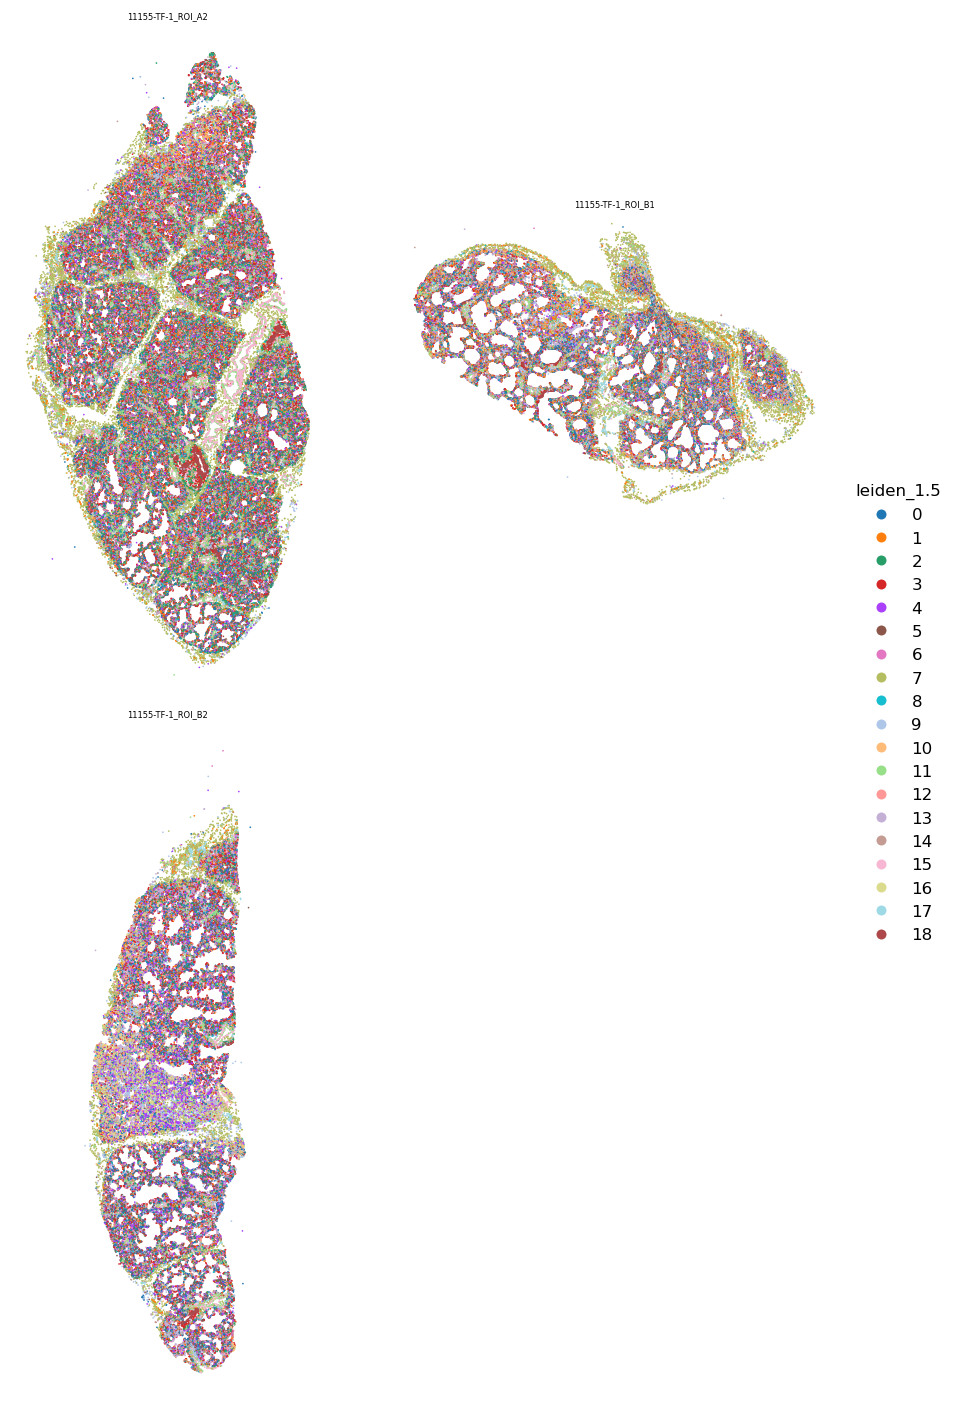

In [ ]:
# usage
spatial_utils.plot_spatial_compact_fast(
    ad,
    color="leiden_1.5",
    groupby="sample_id",
    spot_size=1,
    cols=2,
    height=12,
    legend_col_width=1.0,
)

## Step 27: Plot Per-Run Spatial Maps

Loop over runs and generate one spatial cluster map per run for detailed inspection.

**What this cell does**
- Subsets AnnData by each unique `run` value.
- Plots `leiden_2` assignments in each run independently.


output-XETG00077__0040306__11155-TF-1_ROI_A2__20240621__173354


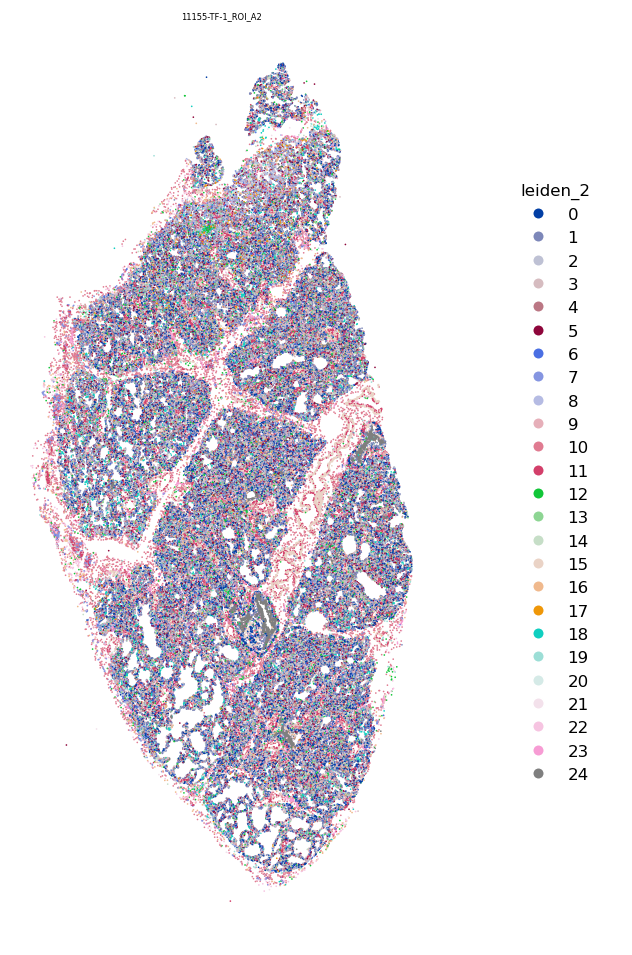

output-XETG00077__0040306__11155-TF-1_ROI_B2__20240621__173354


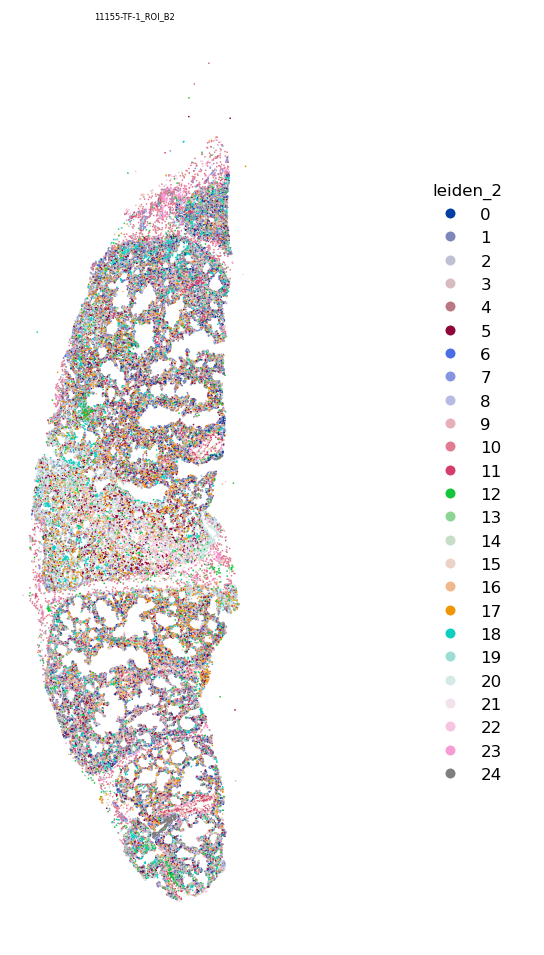

output-XETG00077__0040306__11155-TF-1_ROI_B1__20240621__173354


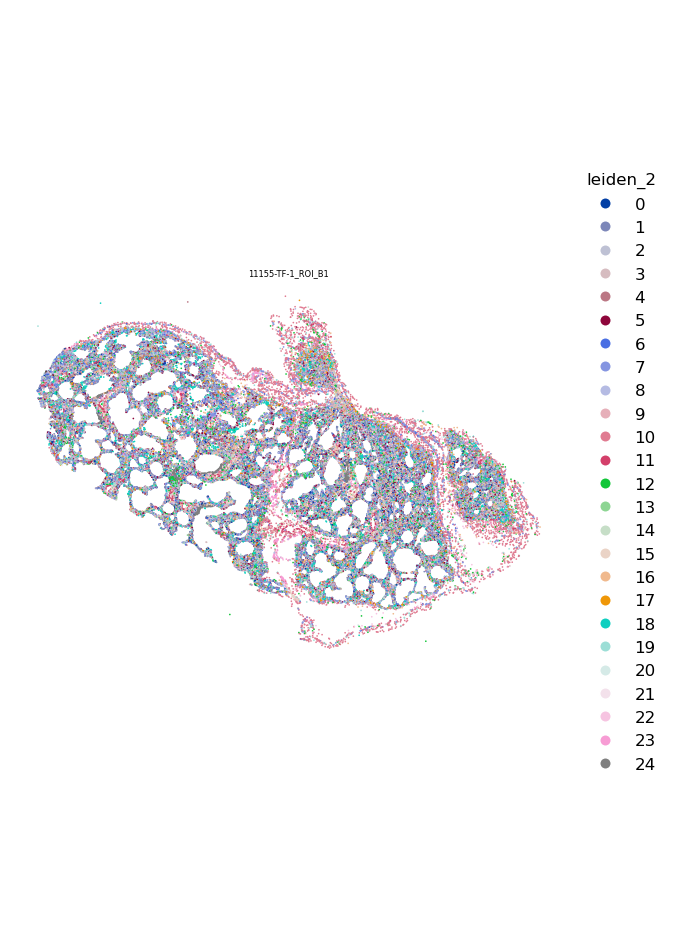

In [ ]:
for run in ad.obs['run'].unique():
    print(run)
    ad_int = ad[ad.obs['run'] == run]
    # usage
    spatial_utils.plot_spatial_compact_fast(
        ad_int,
        color="leiden_2",
        groupby="sample_id",
        spot_size=1,
        cols=1,
        height=8,
        legend_col_width=1.0,
    )
    

## Step 28: Identify Marker Genes Per Cluster

Run differential expression between clusters and preview top-ranked genes.

**What this cell does**
- Uses `sc.tl.rank_genes_groups` with t-test.
- Plots ranked genes and stores a tidy marker table in memory.


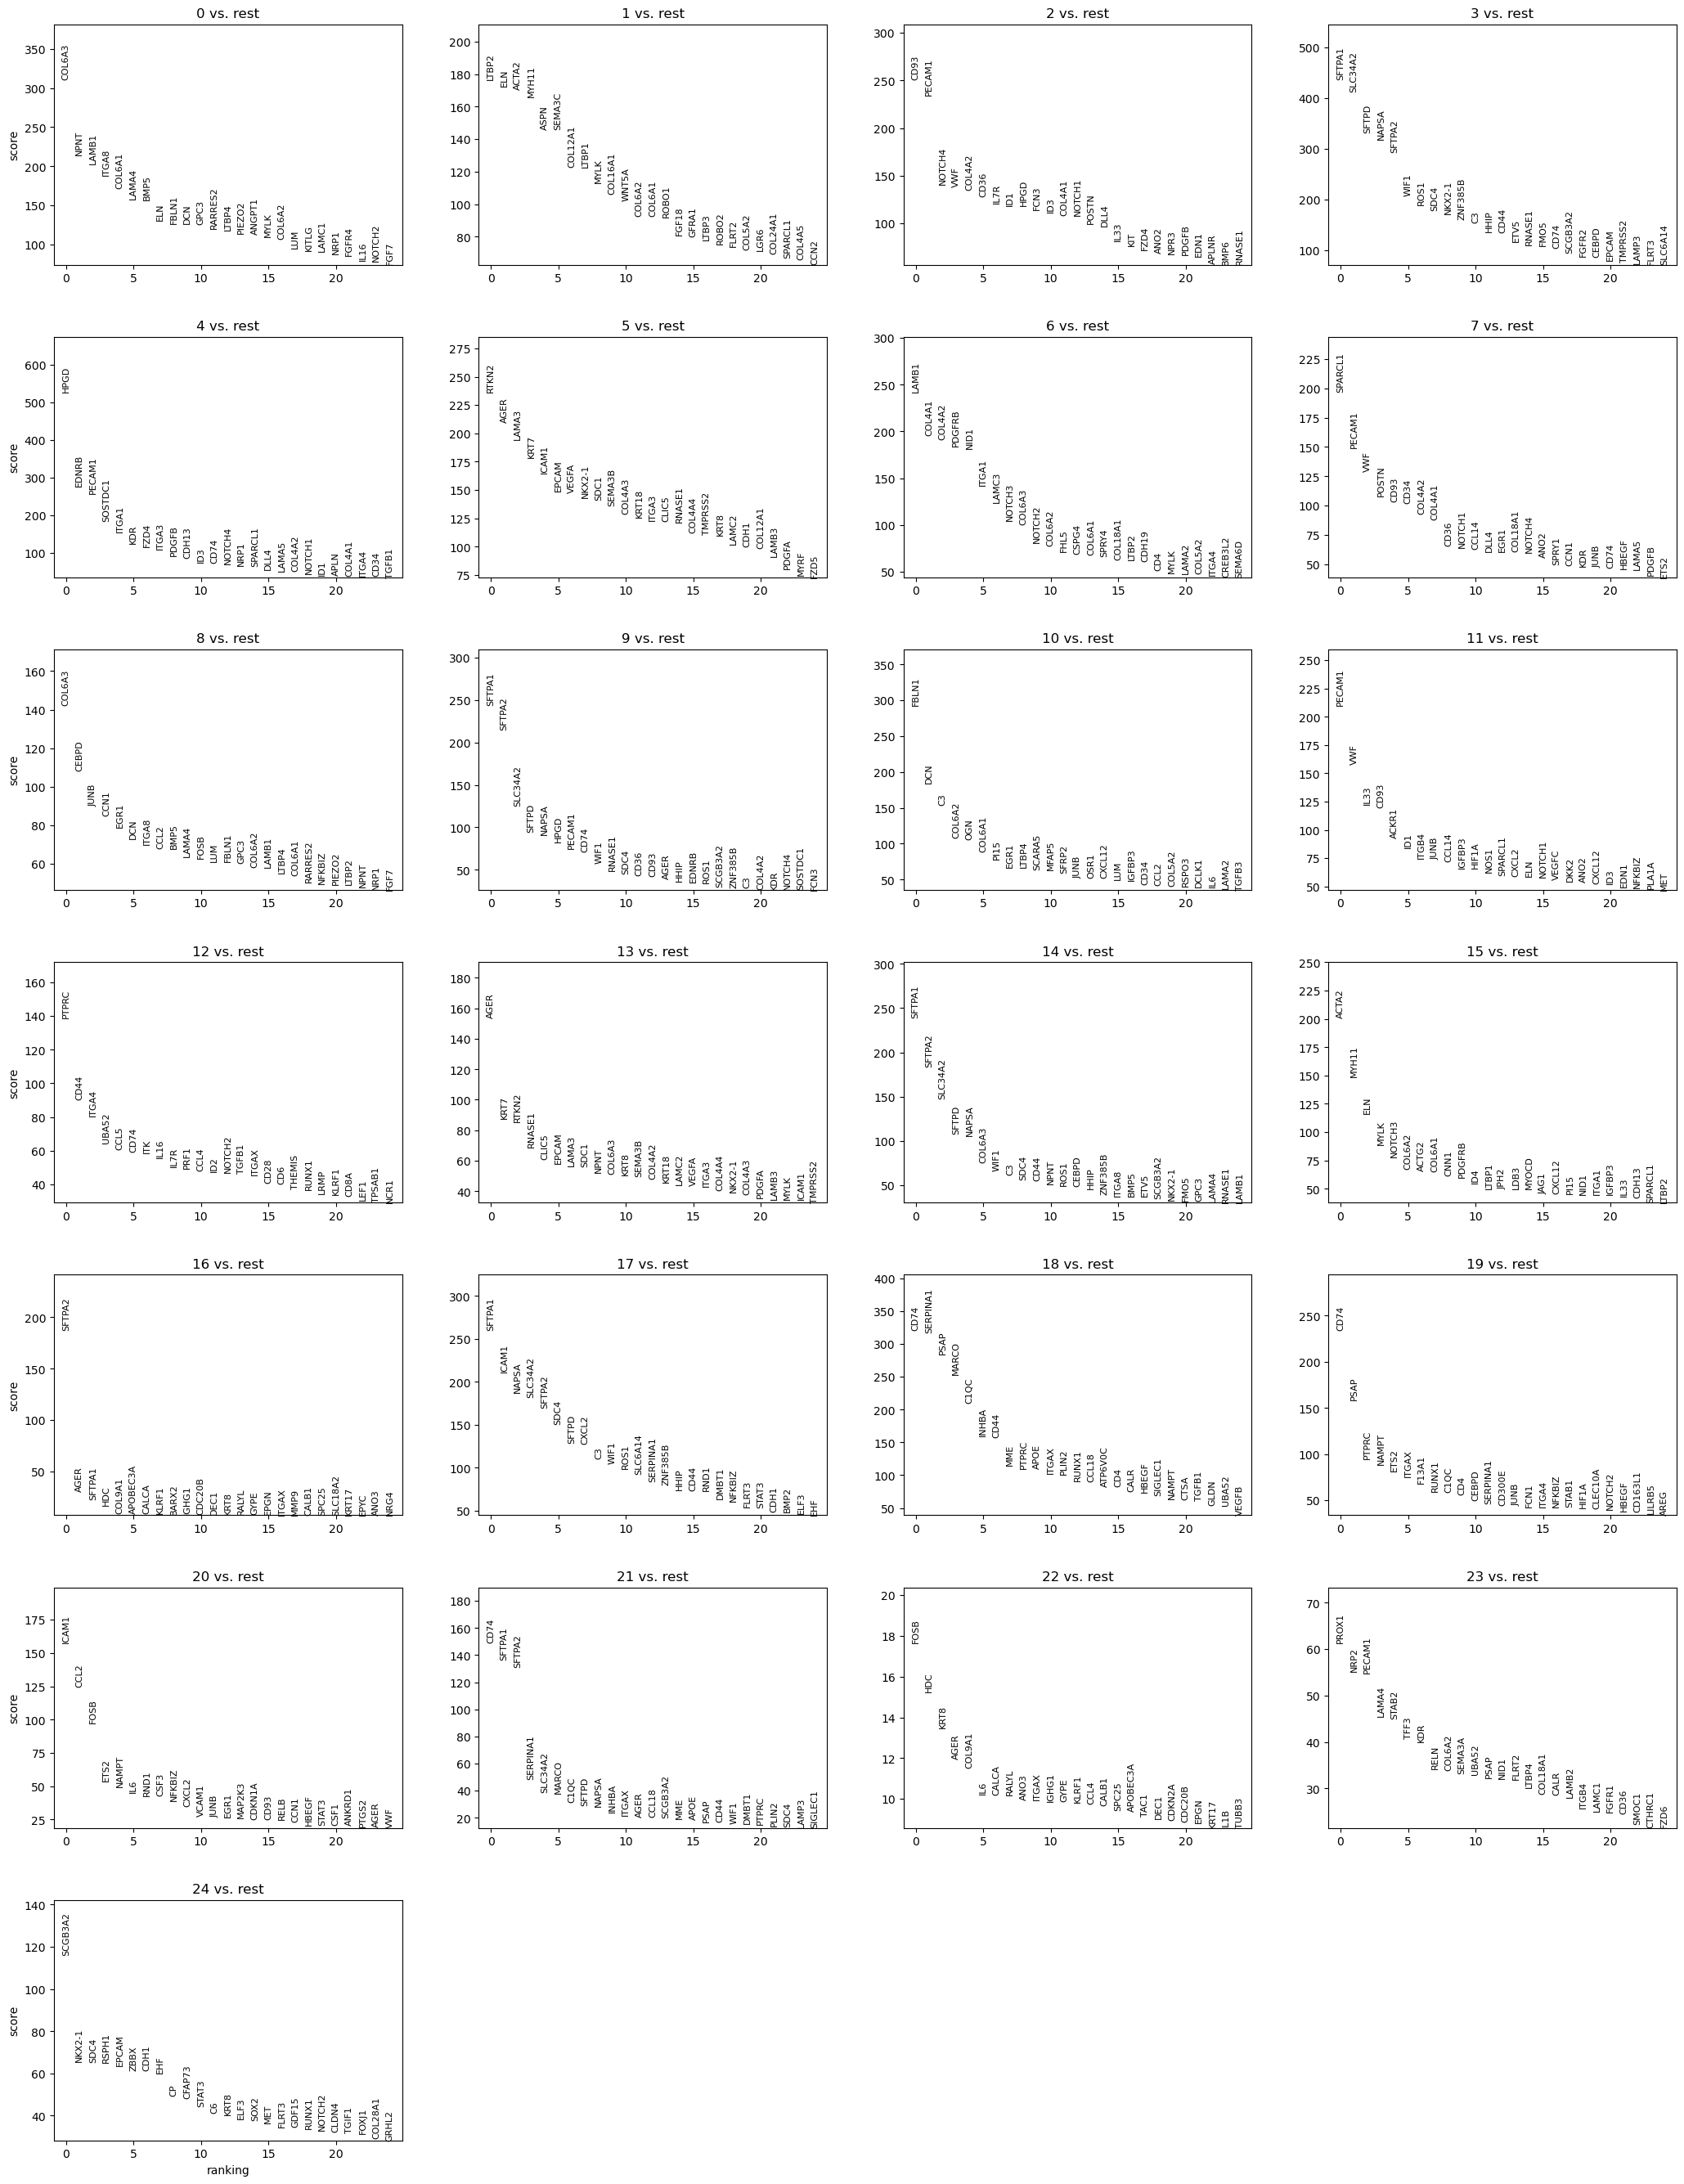

group   names      scores  logfoldchanges  pvals  pvals_adj
0     0  COL6A3  310.711823        2.657168    0.0        0.0
1     0    NPNT  214.671600        2.439867    0.0        0.0
2     0   LAMB1  202.710449        2.289281    0.0        0.0
3     0   ITGA8  188.901428        3.179744    0.0        0.0
4     0  COL6A1  171.371994        1.956414    0.0        0.0

In [ ]:
# --- Find marker genes per cluster ---
sc.tl.rank_genes_groups(ad, groupby="leiden_2", method="t-test")
sc.pl.rank_genes_groups(ad, n_genes=25, sharey=False)

# get a tidy table of top markers
markers = sc.get.rank_genes_groups_df(ad, group=None)
markers.head()

## Step 29: Extract Top Marker Lists For Annotation

Collect top genes for each cluster and print them in a compact format for manual cell-type annotation.

**What this cell does**
- Builds a table of top 30 genes per Leiden cluster.
- Prints each list for quick use in downstream annotation notes.


In [ ]:
marker_genes = pd.DataFrame({
    group: ad.uns['rank_genes_groups']['names'][group][:30]
    for group in ad.uns['rank_genes_groups']['names'].dtype.names
})

for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()
    print(" ".join(genes))
    print(' ')

0
COL6A3 NPNT LAMB1 ITGA8 COL6A1 LAMA4 BMP5 ELN FBLN1 DCN GPC3 RARRES2 LTBP4 PIEZO2 ANGPT1 MYLK COL6A2 LUM KITLG LAMC1 NRP1 FGFR4 IL16 NOTCH2 FGF7 COL5A2 SPARCL1 ROBO2 OLFML3 VEGFD
 
1
LTBP2 ELN ACTA2 MYH11 ASPN SEMA3C COL12A1 LTBP1 MYLK COL16A1 WNT5A COL6A2 COL6A1 ROBO1 FGF18 GFRA1 LTBP3 ROBO2 FLRT2 COL5A2 LGR6 COL24A1 SPARCL1 COL4A5 CCN2 GEM FNDC1 ACTG2 LUZP2 DCN
 
2
CD93 PECAM1 NOTCH4 VWF COL4A2 CD36 IL7R ID1 HPGD FCN3 ID3 COL4A1 NOTCH1 POSTN DLL4 IL33 KIT FZD4 ANO2 NPR3 PDGFB EDN1 APLNR BMP6 RNASE1 AGER ITGA2 TGFB1 KDR LAMA5
 
3
SFTPA1 SLC34A2 SFTPD NAPSA SFTPA2 WIF1 ROS1 SDC4 NKX2-1 ZNF385B C3 HHIP CD44 ETV5 RNASE1 FMO5 CD74 SCGB3A2 FGFR2 CEBPD EPCAM TMPRSS2 LAMP3 FLRT3 SLC6A14 CDH1 EHF FZD5 DMBT1 PLCXD1
 
4
HPGD EDNRB PECAM1 SOSTDC1 ITGA1 KDR FZD4 ITGA3 PDGFB CDH13 ID3 CD74 NOTCH4 NRP1 SPARCL1 DLL4 LAMA5 COL4A2 NOTCH1 ID1 APLN COL4A1 ITGA4 CD34 TGFB1 KITLG PLXNA2 CSF1 LAMB2 SEMA3A
 
5
RTKN2 AGER LAMA3 KRT7 ICAM1 EPCAM VEGFA NKX2-1 SDC1 SEMA3B COL4A3 KRT18 ITGA3 CLIC5 RNASE1 COL4A

## Step 30: Write Final Analysis Object

Save the updated AnnData object after marker analysis and spatial setup.

**What this cell does**
- Overwrites `data/260210_clustered.h5ad` with latest state.
- Keeps one file containing cluster labels and analysis-ready metadata.


In [ ]:
#RENAME
ad.write('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_clustered.h5ad')

In [ ]:
ad = sc.read_h5ad('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_clustered.h5ad')

In [ ]:
# Find HVGs
sc.pp.highly_variable_genes(
    ad,
    n_top_genes=100,
    flavor="seurat_v3"
)


In [ ]:
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything

seed_everything(12345)
scvi.settings.seed = 12345

Seed set to 12345
Seed set to 12345


In [ ]:
scvi.model.SCVI.setup_anndata(
    ad, 
    layer="counts", 
    batch_key='sample_id',
)

model = scvi.model.SCVI(ad)

In [ ]:
model.train(early_stopping=True, enable_progress_bar=True, max_epochs = 30)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Epoch 30/30: 100%|██████████| 30/30 [18:25<00:00, 37.08s/it, v_num=1, train_loss=134]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [18:25<00:00, 36.84s/it, v_num=1, train_loss=134]


In [ ]:
ad.obsm['X_scVI'] = model.get_latent_representation(ad).astype(np.float32)


In [ ]:
sq.gr.spatial_neighbors(ad, library_key='sample_id', coord_type='generic', delaunay=True, percentile=99)


In [ ]:
cc.gr.remove_long_links(ad)


In [ ]:
cc.gr.aggregate_neighbors(ad, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample_id')


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


In [ ]:
# GMM components to try
# GMM components to try
gmm_components = [10, 15,20]



In [ ]:
from sklearn.mixture import GaussianMixture
import pandas as pd

X = ad.obsm['X_cellcharter']
gmm_results = []

for k in gmm_components:
    print(k)
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0,
        n_init=3,
    )
    labels = gmm.fit_predict(X)
    key = f'CellCharter_{k}'
    ad.obs[key] = labels.astype(str)
    gmm_results.append({
        'k': k,
        'bic': gmm.bic(X),
        'aic': gmm.aic(X),
    })
    n_clusters = ad.obs[key].nunique()
    print(f'k={k}: {n_clusters} clusters')


10
k=10: 10 clusters
15
k=15: 15 clusters
20
k=20: 20 clusters


In [ ]:
import sys
sys.path.append("/Users/chrislangseth/work/karolinska_institutet/projects/BaloMS/")
from utils import spatial_utils

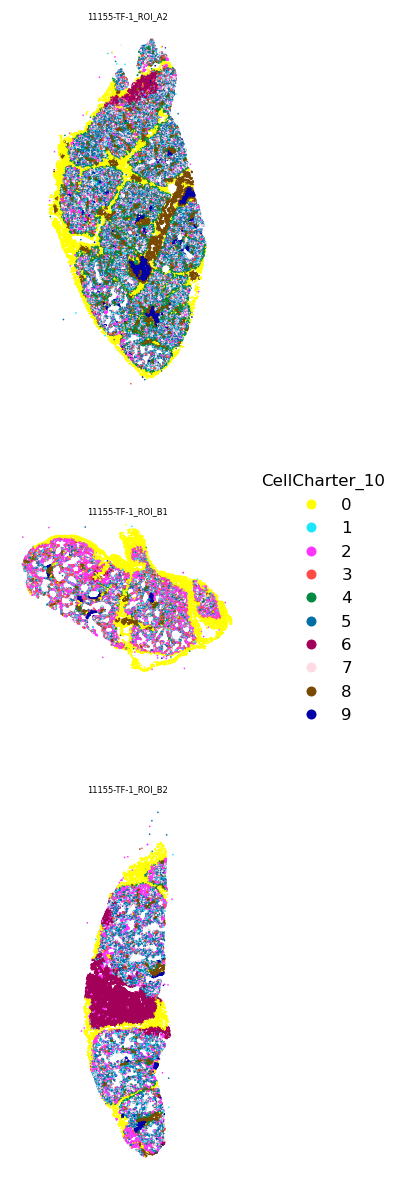

In [ ]:
spatial_utils.plot_spatial_compact_fast(
    ad,
    color="CellCharter_10",
    groupby="sample_id",
    spot_size=1,
    cols=1,
    height=10,
    background="white",
    dpi=120,
)


In [ ]:
ad.write('/Volumes/processing2/xenium_acute_neonatal_lung/fetal_lung_clustered_niche.h5ad')